In [1]:
#TIME WINDOW = 10HR
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


                               DateTime  Voltage Line 1 [V]  \
DateTime                                                      
2020-08-02 00:00:00 2020-08-02 00:00:00              232.39   
2020-08-02 01:00:00 2020-08-02 01:00:00              234.30   
2020-08-02 02:00:00 2020-08-02 02:00:00              234.14   
2020-08-02 03:00:00 2020-08-02 03:00:00              234.99   
2020-08-02 04:00:00 2020-08-02 04:00:00              233.60   
...                                 ...                 ...   
2020-11-30 19:00:00 2020-11-30 19:00:00              233.59   
2020-11-30 20:00:00 2020-11-30 20:00:00              233.99   
2020-11-30 21:00:00 2020-11-30 21:00:00              233.38   
2020-11-30 22:00:00 2020-11-30 22:00:00              233.50   
2020-11-30 23:00:00 2020-11-30 23:00:00              232.89   

                     Voltage Line 2 [V]  Voltage Line 3 [V]  \
DateTime                                                      
2020-08-02 00:00:00              232.27              2

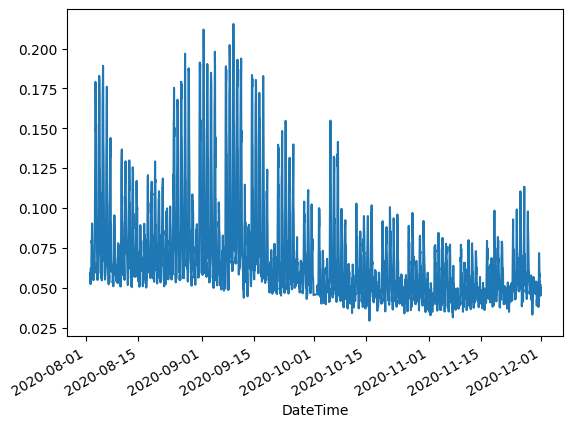

In [2]:
df = pd.read_csv('meter1_combined.csv')
df.DateTime = pd.to_datetime(df.DateTime,dayfirst=True)
df.index = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M:%S')
df["Active Total Energy in MWh"]= df['Active Total Energy (Wh) [Wh]'].astype(float)/ 1000000
df["Combined Active Power in MW"] = df['Combined Active Power Line 1+2 +3 (watt)'].astype(float) / 1000000
print(df)
df['Combined Active Power in MW'].plot()
# plt.show()
target= df['Combined Active Power in MW']
print(target)

In [3]:
target

DateTime
2020-08-02 00:00:00    0.056684
2020-08-02 01:00:00    0.059487
2020-08-02 02:00:00    0.052799
2020-08-02 03:00:00    0.055698
2020-08-02 04:00:00    0.052330
                         ...   
2020-11-30 19:00:00    0.052057
2020-11-30 20:00:00    0.044937
2020-11-30 21:00:00    0.048803
2020-11-30 22:00:00    0.049585
2020-11-30 23:00:00    0.046653
Name: Combined Active Power in MW, Length: 2878, dtype: float64

In [4]:
#Convert TimeSeries
#MODEL WITH JUST POWER
def df_to_X_y(df, window_size=10):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

#Convert TimeSeries
#Uses 5 hrs to predict the next hour ....
WINDOW_SIZE = 10
X1, y1 = df_to_X_y(target, WINDOW_SIZE)
X1.shape, y1.shape

((2868, 10, 1), (2868,))

In [5]:
X_train1, y_train1 = X1[:2000], y1[:2000]
X_val1, y_val1 = X1[2000:2435], y1[2000:2435]
X_test1, y_test1 = X1[2435:], y1[2435:]
print(X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)

(2000, 10, 1) (2000,) (435, 10, 1) (435,) (433, 10, 1) (433,)


In [6]:
model1 = Sequential()
model1.add(InputLayer((10, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [7]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [8]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

Epoch 1/50
63/63 [==============================] - 3s 15ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 2.2537e-04 - val_root_mean_squared_error: 0.0150


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 2/50
63/63 [==============================] - 0s 6ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 4.4995e-04 - val_root_mean_squared_error: 0.0212
Epoch 3/50
63/63 [==============================] - 0s 6ms/step - loss: 8.9564e-04 - root_mean_squared_error: 0.0299 - val_loss: 4.6029e-04 - val_root_mean_squared_error: 0.0215
Epoch 4/50
63/63 [==============================] - 0s 5ms/step - loss: 8.9126e-04 - root_mean_squared_error: 0.0298 - val_loss: 4.0302e-04 - val_root_mean_squared_error: 0.0201
Epoch 5/50
63/63 [==============================] - 0s 5ms/step - loss: 8.4911e-04 - root_mean_squared_error: 0.0291 - val_loss: 3.8099e-04 - val_root_mean_squared_error: 0.0195
Epoch 6/50
63/63 [==============================] - 0s 5ms/step - loss: 8.4005e-04 - root_mean_squared_error: 0.0290 - val_loss: 4.0121e-04 - val_root_mean_squared_error: 0.0200
Epoch 7/50
63/63 [==============================] - 0s 5ms/step - loss: 7.9289e-04 - root_mean_squared_error: 0.02

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 25/50
63/63 [==============================] - 0s 5ms/step - loss: 3.9584e-04 - root_mean_squared_error: 0.0199 - val_loss: 2.8518e-04 - val_root_mean_squared_error: 0.0169
Epoch 26/50
63/63 [==============================] - 0s 5ms/step - loss: 3.9544e-04 - root_mean_squared_error: 0.0199 - val_loss: 2.6514e-04 - val_root_mean_squared_error: 0.0163
Epoch 27/50
63/63 [==============================] - 0s 6ms/step - loss: 3.4714e-04 - root_mean_squared_error: 0.0186 - val_loss: 2.8884e-04 - val_root_mean_squared_error: 0.0170
Epoch 28/50
63/63 [==============================] - 0s 5ms/step - loss: 3.6868e-04 - root_mean_squared_error: 0.0192 - val_loss: 2.3375e-04 - val_root_mean_squared_error: 0.0153
Epoch 29/50
63/63 [==============================] - 0s 5ms/step - loss: 3.9041e-04 - root_mean_squared_error: 0.0197 - val_loss: 1.9840e-04 - val_root_mean_squared_error: 0.0141


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 30/50
63/63 [==============================] - 0s 6ms/step - loss: 3.8274e-04 - root_mean_squared_error: 0.0195 - val_loss: 2.2727e-04 - val_root_mean_squared_error: 0.0151
Epoch 31/50
63/63 [==============================] - 0s 5ms/step - loss: 3.6909e-04 - root_mean_squared_error: 0.0192 - val_loss: 2.2251e-04 - val_root_mean_squared_error: 0.0149
Epoch 32/50
63/63 [==============================] - 0s 5ms/step - loss: 3.5983e-04 - root_mean_squared_error: 0.0190 - val_loss: 1.9799e-04 - val_root_mean_squared_error: 0.0141


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 33/50
63/63 [==============================] - 0s 6ms/step - loss: 3.4402e-04 - root_mean_squared_error: 0.0185 - val_loss: 1.8838e-04 - val_root_mean_squared_error: 0.0137


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 34/50
63/63 [==============================] - 0s 6ms/step - loss: 3.5111e-04 - root_mean_squared_error: 0.0187 - val_loss: 1.7150e-04 - val_root_mean_squared_error: 0.0131


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 35/50
63/63 [==============================] - 0s 6ms/step - loss: 3.3741e-04 - root_mean_squared_error: 0.0184 - val_loss: 2.6244e-04 - val_root_mean_squared_error: 0.0162
Epoch 36/50
63/63 [==============================] - 0s 5ms/step - loss: 3.3486e-04 - root_mean_squared_error: 0.0183 - val_loss: 2.1935e-04 - val_root_mean_squared_error: 0.0148
Epoch 37/50
63/63 [==============================] - 0s 5ms/step - loss: 3.5103e-04 - root_mean_squared_error: 0.0187 - val_loss: 1.3065e-04 - val_root_mean_squared_error: 0.0114


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 38/50
63/63 [==============================] - 0s 5ms/step - loss: 3.1683e-04 - root_mean_squared_error: 0.0178 - val_loss: 1.7973e-04 - val_root_mean_squared_error: 0.0134
Epoch 39/50
63/63 [==============================] - 0s 6ms/step - loss: 2.6849e-04 - root_mean_squared_error: 0.0164 - val_loss: 2.0645e-04 - val_root_mean_squared_error: 0.0144
Epoch 40/50
63/63 [==============================] - 0s 5ms/step - loss: 3.2671e-04 - root_mean_squared_error: 0.0180 - val_loss: 1.9402e-04 - val_root_mean_squared_error: 0.0139
Epoch 41/50
63/63 [==============================] - 0s 5ms/step - loss: 2.9276e-04 - root_mean_squared_error: 0.0171 - val_loss: 2.1319e-04 - val_root_mean_squared_error: 0.0146
Epoch 42/50
63/63 [==============================] - 0s 5ms/step - loss: 2.7154e-04 - root_mean_squared_error: 0.0165 - val_loss: 2.0185e-04 - val_root_mean_squared_error: 0.0142
Epoch 43/50
63/63 [==============================] - 0s 5ms/step - loss: 2.8959e-04 - root_mean_squared_e

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 49/50
63/63 [==============================] - 0s 6ms/step - loss: 2.4154e-04 - root_mean_squared_error: 0.0155 - val_loss: 1.2605e-04 - val_root_mean_squared_error: 0.0112
Epoch 50/50
63/63 [==============================] - 0s 5ms/step - loss: 2.4918e-04 - root_mean_squared_error: 0.0158 - val_loss: 1.1869e-04 - val_root_mean_squared_error: 0.0109


In [9]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})

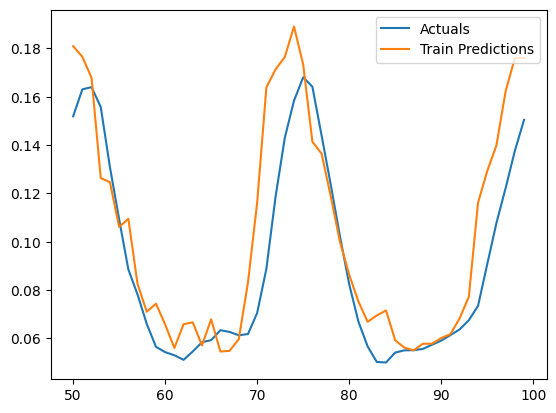

In [10]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])
plt.legend(['Actuals','Train Predictions'])
plt.show()

In [11]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

,Val Predictions,Actuals
0,0.059706,0.045278
1,0.057613,0.043687
2,0.055376,0.043196
3,0.053955,0.043147
4,0.053110,0.040058
...,...,...
430,0.064656,0.051650
431,0.059371,0.052649
432,0.056594,0.044108
433,0.052763,0.045328


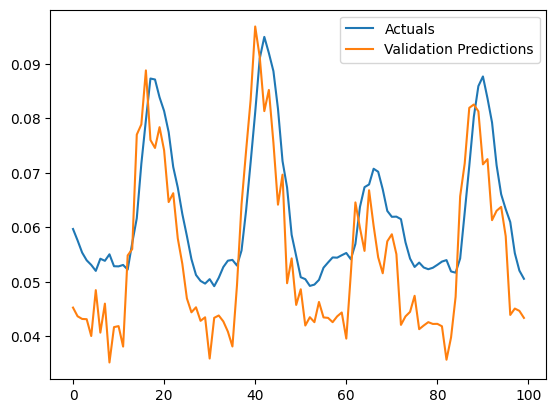

In [12]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])
plt.legend(['Actuals','Validation Predictions'])

In [13]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1},index=df['DateTime'][2445:].index)
test_results

,Test Predictions,Actuals
DateTime,,
2020-11-12 23:00:00,0.048803,0.045142
2020-11-13 00:00:00,0.049913,0.041819
2020-11-13 01:00:00,0.050642,0.040095
2020-11-13 02:00:00,0.051059,0.046965
2020-11-13 03:00:00,0.053679,0.047540
...,...,...
2020-11-30 19:00:00,0.056383,0.052057
2020-11-30 20:00:00,0.055943,0.044937
2020-11-30 21:00:00,0.054453,0.048803


In [14]:
# print(target.head())
# plt.plot(test_results['Test Predictions'])#[:100])
# plt.plot(target)#[:100])
# # plt.legend(['Actuals','Test Predictions'])
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error as mse
# from sklearn.metrics import r2_score as r2
# from sklearn.metrics import mean_absolute_percentage_error as mape

# def plot_predictions2(model, X, y, y_all):
#     predictions = model.predict(X).flatten()
#     df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y, 'Target': y_all})
#     plt.plot(df[['Actuals', 'Target']])
#     plt.plot(df['Predictions'])
#     plt.legend(['Actuals', 'Target', 'Test Predictions'])
#     return df, mse(y, predictions), r2(y, predictions), mape(y, predictions)

# final, mse_val, r2_val, mape_value = plot_predictions2(model1, X_test1, y_test1, target)
# print(mse_val, r2_val, mape_value)



Text(0, 0.5, 'Active Power in MW')

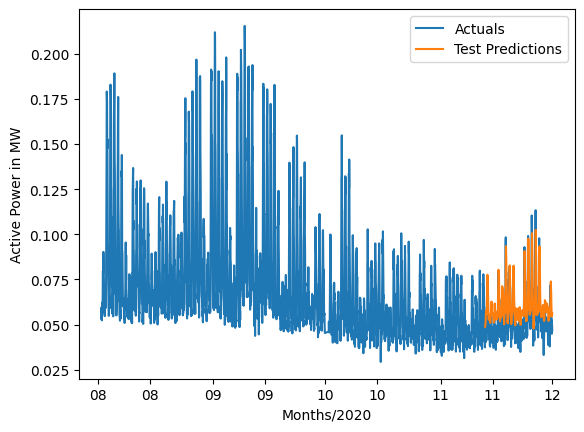

In [15]:
#fig=plt.plot(test_results['Test Predictions'])#[:100])
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m'))
fig=plt.plot(target)#[:100])    
fig=plt.plot(test_results['Test Predictions']) 
plt.legend(['Actuals','Test Predictions'])    
plt.xlabel("Months/2020")
plt.ylabel("Active Power in MW")                           
#fig.autofmt_xdate()

In [16]:
scores = model1.evaluate(X_test1, y_test1)

LSTM_accuracy = scores[1]*10000

print('Test accuracy: ', LSTM_accuracy, '%')

14/14 [==============================] - 0s 2ms/step - loss: 1.1964e-04 - root_mean_squared_error: 0.0109
Test accuracy:  109.38064195215702 %


0.00011964124714082 0.34987038990754193 0.19125445886296574


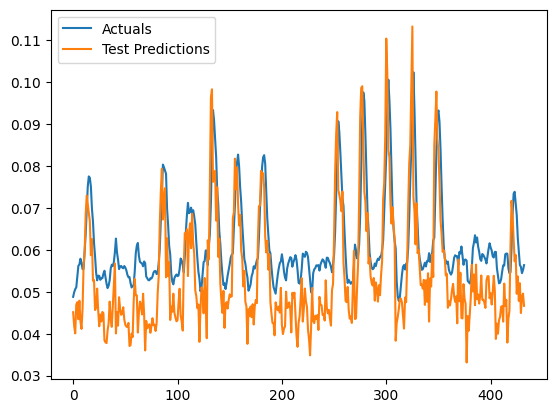

In [17]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_percentage_error as mape

def plot_predictions1(model, X, y):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])
  plt.legend(['Actuals','Test Predictions'])
  return df, mse(y, predictions), r2(y,predictions), mape (y,predictions)

final, mse_val, r2_val, mape_value = plot_predictions1(model1, X_test1, y_test1)
print(mse_val, r2_val, mape_value)

In [18]:
target.head()

DateTime
2020-08-02 00:00:00    0.056684
2020-08-02 01:00:00    0.059487
2020-08-02 02:00:00    0.052799
2020-08-02 03:00:00    0.055698
2020-08-02 04:00:00    0.052330
Name: Combined Active Power in MW, dtype: float64

In [19]:
#Weather Data + Time
temp_df = pd.DataFrame({'Power':target,"Avg Temp":df["Temp"],"High Temp":df['Hi'],"Low Temp":df["Low"]})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Power,Avg Temp,High Temp,Low Temp,Seconds
DateTime,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,1.596326e+09
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,1.596330e+09
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,1.596334e+09
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,1.596337e+09
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,1.596341e+09
...,...,...,...,...,...
2020-11-30 19:00:00,0.052057,14.4,15.1,14.1,1.606763e+09
2020-11-30 20:00:00,0.044937,13.7,14.2,13.3,1.606766e+09
2020-11-30 21:00:00,0.048803,13.4,13.7,13.2,1.606770e+09


In [20]:
#Adding into consideration the time as a periodic function

day = 60*60*24
month= 30*day
temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Month sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / month))
temp_df['Month cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / month))
temp_df

,Power,Avg Temp,High Temp,Low Temp,Seconds,Day sin,Day cos,Month sin,Month cos
DateTime,,,,,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,1.596326e+09,-4.553737e-12,1.000000,-0.743145,0.669131
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,1.596330e+09,2.588190e-01,0.965926,-0.737277,0.675590
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,1.596334e+09,5.000000e-01,0.866025,-0.731354,0.681998
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,1.596337e+09,7.071068e-01,0.707107,-0.725374,0.688355
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,1.596341e+09,8.660254e-01,0.500000,-0.719340,0.694658
...,...,...,...,...,...,...,...,...,...
2020-11-30 19:00:00,0.052057,14.4,15.1,14.1,1.606763e+09,-9.659258e-01,0.258819,-0.622515,0.782608
2020-11-30 20:00:00,0.044937,13.7,14.2,13.3,1.606766e+09,-8.660254e-01,0.500000,-0.615661,0.788011
2020-11-30 21:00:00,0.048803,13.4,13.7,13.2,1.606770e+09,-7.071068e-01,0.707107,-0.608761,0.793353


In [21]:
temp_df.drop("Seconds",axis=1,inplace=True)
temp_df.head()

,Power,Avg Temp,High Temp,Low Temp,Day sin,Day cos,Month sin,Month cos
DateTime,,,,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,-4.553737e-12,1.000000,-0.743145,0.669131
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,2.588190e-01,0.965926,-0.737277,0.675590
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,5.000000e-01,0.866025,-0.731354,0.681998
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,7.071068e-01,0.707107,-0.725374,0.688355
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,8.660254e-01,0.500000,-0.719340,0.694658


In [22]:
#Function to create timeseries for multiple parameters
def df_to_X_y2(df, window_size=1):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [23]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((2877, 1, 8), (2877,))

In [24]:
X2_train, y2_train = X2[:2000], y2[:2000]
X2_val, y2_val = X2[2000:2435], y2[2000:2435]
X2_test, y2_test = X2[2435:], y2[2435:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((2000, 1, 8), (2000,), (435, 1, 8), (435,), (442, 1, 8), (442,))

In [25]:
#Standardization for the temperatures. Dividing mean/std 
avg_temp_training_mean = np.mean(X2_train[:, :, 1])
avg_temp_training_std = np.std(X2_train[:, :, 1])
hi_temp_training_mean=np.mean(X2_train[:, :, 2])
hi_temp_training_std=np.std(X2_train[:, :, 2])
low_temp_training_mean = np.mean(X2_train[:, :, 3])
low_temp_training_std=np.std(X2_train[:, :, 3])

def preprocess(X):
  X[:, :, 1] = (X[:, :, 1] - avg_temp_training_mean) / avg_temp_training_std
  X[:, :, 2] = (X[:, :, 2] - hi_temp_training_mean) / hi_temp_training_std
  X[:, :, 3] = (X[:, :, 3] - low_temp_training_mean) / low_temp_training_std
  return X

preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 0.07168051, -1.02806753, -1.05114388, ..., -0.96592583,
          0.97629601, -0.21643961]],

       [[ 0.07084134, -0.94875434, -1.03141483, ..., -0.8660254 ,
          0.97437006, -0.22495105]],

       [[ 0.06864545, -0.92892604, -0.99195674, ..., -0.70710678,
          0.97236992, -0.23344536]],

       ...,

       [[ 0.04493744, -2.35656353, -2.35326096, ...,  0.5       ,
         -0.61566148,  0.78801075]],

       [[ 0.04880258, -2.41604843, -2.4519062 , ...,  0.70710678,
         -0.60876143,  0.79335334]],

       [[ 0.04958546, -2.45570503, -2.4519062 , ...,  0.8660254 ,
         -0.60181502,  0.79863551]]])

In [26]:
model4 = Sequential()
model4.add(InputLayer((1, 8)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18688     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 19,217
Trainable params: 19,217
Non-trainable params: 0
_________________________________________________________________


In [27]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [28]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp4])

Epoch 1/50
63/63 [==============================] - 3s 10ms/step - loss: 0.0110 - root_mean_squared_error: 0.1047 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 2/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0040 - root_mean_squared_error: 0.0628 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 3/50
63/63 [==============================] - 0s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 8.8419e-04 - val_root_mean_squared_error: 0.0297


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 4/50
63/63 [==============================] - 0s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 8.3246e-04 - val_root_mean_squared_error: 0.0289


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 5/50
63/63 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 8.0160e-04 - val_root_mean_squared_error: 0.0283


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 6/50
63/63 [==============================] - 0s 2ms/step - loss: 8.3548e-04 - root_mean_squared_error: 0.0289 - val_loss: 7.6237e-04 - val_root_mean_squared_error: 0.0276


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 7/50
63/63 [==============================] - 0s 3ms/step - loss: 7.8108e-04 - root_mean_squared_error: 0.0279 - val_loss: 6.9156e-04 - val_root_mean_squared_error: 0.0263


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 8/50
63/63 [==============================] - 0s 2ms/step - loss: 6.8755e-04 - root_mean_squared_error: 0.0262 - val_loss: 6.1274e-04 - val_root_mean_squared_error: 0.0248


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 9/50
63/63 [==============================] - 0s 2ms/step - loss: 6.4405e-04 - root_mean_squared_error: 0.0254 - val_loss: 5.6235e-04 - val_root_mean_squared_error: 0.0237


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 10/50
63/63 [==============================] - 0s 2ms/step - loss: 5.6189e-04 - root_mean_squared_error: 0.0237 - val_loss: 4.7915e-04 - val_root_mean_squared_error: 0.0219


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 11/50
63/63 [==============================] - 0s 2ms/step - loss: 5.1487e-04 - root_mean_squared_error: 0.0227 - val_loss: 4.2374e-04 - val_root_mean_squared_error: 0.0206


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 12/50
63/63 [==============================] - 0s 2ms/step - loss: 5.0948e-04 - root_mean_squared_error: 0.0226 - val_loss: 4.0628e-04 - val_root_mean_squared_error: 0.0202


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 13/50
63/63 [==============================] - 0s 2ms/step - loss: 4.8903e-04 - root_mean_squared_error: 0.0221 - val_loss: 3.5165e-04 - val_root_mean_squared_error: 0.0188


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 14/50
63/63 [==============================] - 0s 2ms/step - loss: 5.0037e-04 - root_mean_squared_error: 0.0223 - val_loss: 3.3869e-04 - val_root_mean_squared_error: 0.0184


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 15/50
63/63 [==============================] - 0s 2ms/step - loss: 4.7211e-04 - root_mean_squared_error: 0.0217 - val_loss: 3.1398e-04 - val_root_mean_squared_error: 0.0177


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 16/50
63/63 [==============================] - 0s 2ms/step - loss: 4.8099e-04 - root_mean_squared_error: 0.0219 - val_loss: 3.0088e-04 - val_root_mean_squared_error: 0.0173


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 17/50
63/63 [==============================] - 0s 2ms/step - loss: 4.5059e-04 - root_mean_squared_error: 0.0212 - val_loss: 2.9798e-04 - val_root_mean_squared_error: 0.0173


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 18/50
63/63 [==============================] - 0s 2ms/step - loss: 4.2774e-04 - root_mean_squared_error: 0.0207 - val_loss: 3.0219e-04 - val_root_mean_squared_error: 0.0174
Epoch 19/50
63/63 [==============================] - 0s 2ms/step - loss: 4.6182e-04 - root_mean_squared_error: 0.0215 - val_loss: 2.6776e-04 - val_root_mean_squared_error: 0.0164


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 20/50
63/63 [==============================] - 0s 2ms/step - loss: 4.3217e-04 - root_mean_squared_error: 0.0208 - val_loss: 2.8176e-04 - val_root_mean_squared_error: 0.0168
Epoch 21/50
63/63 [==============================] - 0s 2ms/step - loss: 4.3183e-04 - root_mean_squared_error: 0.0208 - val_loss: 2.6991e-04 - val_root_mean_squared_error: 0.0164
Epoch 22/50
63/63 [==============================] - 0s 2ms/step - loss: 3.9049e-04 - root_mean_squared_error: 0.0197 - val_loss: 2.6353e-04 - val_root_mean_squared_error: 0.0162


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 23/50
63/63 [==============================] - 0s 2ms/step - loss: 3.9411e-04 - root_mean_squared_error: 0.0198 - val_loss: 2.7255e-04 - val_root_mean_squared_error: 0.0165
Epoch 24/50
63/63 [==============================] - 0s 2ms/step - loss: 4.2534e-04 - root_mean_squared_error: 0.0206 - val_loss: 2.5101e-04 - val_root_mean_squared_error: 0.0158


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 25/50
63/63 [==============================] - 0s 3ms/step - loss: 4.0030e-04 - root_mean_squared_error: 0.0200 - val_loss: 2.5770e-04 - val_root_mean_squared_error: 0.0161
Epoch 26/50
63/63 [==============================] - 0s 3ms/step - loss: 4.0266e-04 - root_mean_squared_error: 0.0201 - val_loss: 2.5862e-04 - val_root_mean_squared_error: 0.0161
Epoch 27/50
63/63 [==============================] - 0s 3ms/step - loss: 4.0174e-04 - root_mean_squared_error: 0.0200 - val_loss: 2.2538e-04 - val_root_mean_squared_error: 0.0150


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 28/50
63/63 [==============================] - 0s 2ms/step - loss: 3.9260e-04 - root_mean_squared_error: 0.0198 - val_loss: 2.6329e-04 - val_root_mean_squared_error: 0.0162
Epoch 29/50
63/63 [==============================] - 0s 2ms/step - loss: 4.0249e-04 - root_mean_squared_error: 0.0201 - val_loss: 2.4101e-04 - val_root_mean_squared_error: 0.0155
Epoch 30/50
63/63 [==============================] - 0s 2ms/step - loss: 4.0136e-04 - root_mean_squared_error: 0.0200 - val_loss: 2.3880e-04 - val_root_mean_squared_error: 0.0155
Epoch 31/50
63/63 [==============================] - 0s 2ms/step - loss: 3.8648e-04 - root_mean_squared_error: 0.0197 - val_loss: 2.1928e-04 - val_root_mean_squared_error: 0.0148


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 32/50
63/63 [==============================] - 0s 2ms/step - loss: 3.7846e-04 - root_mean_squared_error: 0.0195 - val_loss: 1.9848e-04 - val_root_mean_squared_error: 0.0141


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 33/50
63/63 [==============================] - 0s 2ms/step - loss: 3.5299e-04 - root_mean_squared_error: 0.0188 - val_loss: 2.1419e-04 - val_root_mean_squared_error: 0.0146
Epoch 34/50
63/63 [==============================] - 0s 2ms/step - loss: 3.5897e-04 - root_mean_squared_error: 0.0189 - val_loss: 1.9731e-04 - val_root_mean_squared_error: 0.0140


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 35/50
63/63 [==============================] - 0s 2ms/step - loss: 3.3814e-04 - root_mean_squared_error: 0.0184 - val_loss: 1.8409e-04 - val_root_mean_squared_error: 0.0136


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 36/50
63/63 [==============================] - 0s 3ms/step - loss: 3.3357e-04 - root_mean_squared_error: 0.0183 - val_loss: 1.9049e-04 - val_root_mean_squared_error: 0.0138
Epoch 37/50
63/63 [==============================] - 0s 2ms/step - loss: 3.5296e-04 - root_mean_squared_error: 0.0188 - val_loss: 1.9216e-04 - val_root_mean_squared_error: 0.0139
Epoch 38/50
63/63 [==============================] - 0s 2ms/step - loss: 3.2830e-04 - root_mean_squared_error: 0.0181 - val_loss: 1.7877e-04 - val_root_mean_squared_error: 0.0134


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 39/50
63/63 [==============================] - 0s 2ms/step - loss: 3.4594e-04 - root_mean_squared_error: 0.0186 - val_loss: 1.8017e-04 - val_root_mean_squared_error: 0.0134
Epoch 40/50
63/63 [==============================] - 0s 2ms/step - loss: 3.1593e-04 - root_mean_squared_error: 0.0178 - val_loss: 1.9471e-04 - val_root_mean_squared_error: 0.0140
Epoch 41/50
63/63 [==============================] - 0s 2ms/step - loss: 3.5004e-04 - root_mean_squared_error: 0.0187 - val_loss: 1.9462e-04 - val_root_mean_squared_error: 0.0140
Epoch 42/50
63/63 [==============================] - 0s 2ms/step - loss: 3.3736e-04 - root_mean_squared_error: 0.0184 - val_loss: 1.7461e-04 - val_root_mean_squared_error: 0.0132


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 43/50
63/63 [==============================] - 0s 2ms/step - loss: 3.0166e-04 - root_mean_squared_error: 0.0174 - val_loss: 1.7452e-04 - val_root_mean_squared_error: 0.0132


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 44/50
63/63 [==============================] - 0s 2ms/step - loss: 3.0384e-04 - root_mean_squared_error: 0.0174 - val_loss: 1.6822e-04 - val_root_mean_squared_error: 0.0130


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 45/50
63/63 [==============================] - 0s 2ms/step - loss: 3.2816e-04 - root_mean_squared_error: 0.0181 - val_loss: 1.7426e-04 - val_root_mean_squared_error: 0.0132
Epoch 46/50
63/63 [==============================] - 0s 2ms/step - loss: 3.0249e-04 - root_mean_squared_error: 0.0174 - val_loss: 1.6779e-04 - val_root_mean_squared_error: 0.0130


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 47/50
63/63 [==============================] - 0s 3ms/step - loss: 2.8883e-04 - root_mean_squared_error: 0.0170 - val_loss: 1.7375e-04 - val_root_mean_squared_error: 0.0132
Epoch 48/50
63/63 [==============================] - 0s 2ms/step - loss: 3.2621e-04 - root_mean_squared_error: 0.0180 - val_loss: 1.6491e-04 - val_root_mean_squared_error: 0.0128


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 49/50
63/63 [==============================] - 0s 2ms/step - loss: 2.8816e-04 - root_mean_squared_error: 0.0170 - val_loss: 1.6889e-04 - val_root_mean_squared_error: 0.0130
Epoch 50/50
63/63 [==============================] - 0s 2ms/step - loss: 2.9090e-04 - root_mean_squared_error: 0.0170 - val_loss: 1.7401e-04 - val_root_mean_squared_error: 0.0132


14/14 [==============================] - 0s 769us/step - loss: 1.3993e-04 - root_mean_squared_error: 0.0118
Test accuracy:  1.1829003691673279 %


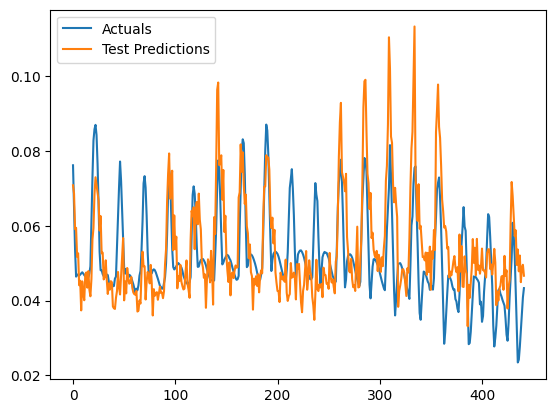

In [29]:
plot_predictions1(model4, X2_test, y2_test)
from keras.models import load_model

model = load_model('model4')
scores = model4.evaluate(X2_test, y2_test)

LSTM_accuracy = scores[1]*100

print('Test accuracy: ', LSTM_accuracy, '%')

63/63 [==============================] - 0s 790us/step - loss: 2.7683e-04 - root_mean_squared_error: 0.0166
Test accuracy:  1.663815788924694 %


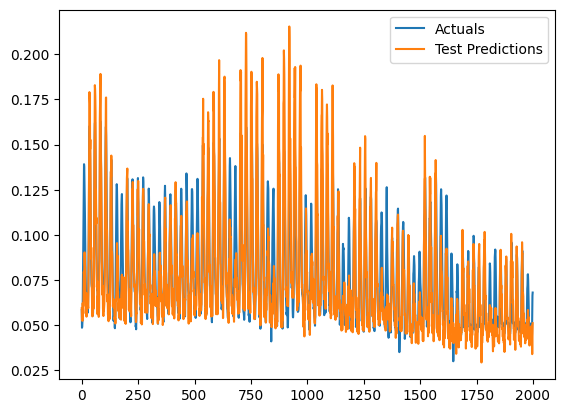

In [30]:
plot_predictions1(model4, X2_train, y2_train)
from keras.models import load_model

model = load_model('model4')
scores = model4.evaluate(X2_train, y2_train)

LSTM_accuracy = scores[1]*100

print('Test accuracy: ', LSTM_accuracy, '%')

In [31]:
#Prediction without using time as a parameter (Just Temperature)
new_df= pd.DataFrame({'Power':target,"Avg Temp":df["Temp"],"High Temp":df['Hi'],"Low Temp":df["Low"]})
new_df

,Power,Avg Temp,High Temp,Low Temp
DateTime,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1
...,...,...,...,...
2020-11-30 19:00:00,0.052057,14.4,15.1,14.1
2020-11-30 20:00:00,0.044937,13.7,14.2,13.3
2020-11-30 21:00:00,0.048803,13.4,13.7,13.2


In [32]:
X3, y3 = df_to_X_y2(new_df)
X3.shape, y3.shape

((2877, 1, 4), (2877,))

In [33]:
X3_train, y3_train = X3[:2000], y3[:2000]
X3_val, y3_val = X3[2000:2435], y3[2000:2435]
X3_test, y3_test = X3[2435:], y3[2435:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((2000, 1, 4), (2000,), (435, 1, 4), (435,), (442, 1, 4), (442,))

In [34]:
avg_temp_training_mean = np.mean(X3_train[:, :, 1])
avg_temp_training_std = np.std(X3_train[:, :, 1])
hi_temp_training_mean=np.mean(X3_train[:, :, 2])
hi_temp_training_std=np.std(X3_train[:, :, 2])
low_temp_training_mean = np.mean(X3_train[:, :, 3])
low_temp_training_std=np.std(X3_train[:, :, 3])

def preprocess(X):
  X[:, :, 1] = (X[:, :, 1] - avg_temp_training_mean) / avg_temp_training_std
  X[:, :, 2] = (X[:, :, 2] - hi_temp_training_mean) / hi_temp_training_std
  X[:, :, 3] = (X[:, :, 3] - low_temp_training_mean) / low_temp_training_std
  return X

preprocess(X3_train)
preprocess(X3_val)
preprocess(X3_test)

array([[[ 0.07168051, -1.02806753, -1.05114388, -0.96496654]],

       [[ 0.07084134, -0.94875434, -1.03141483, -0.86534578]],

       [[ 0.06864545, -0.92892604, -0.99195674, -0.88526993]],

       ...,

       [[ 0.04493744, -2.35656353, -2.35326096, -2.33973304]],

       [[ 0.04880258, -2.41604843, -2.4519062 , -2.35965719]],

       [[ 0.04958546, -2.45570503, -2.4519062 , -2.45927795]]])

In [35]:
model5 = Sequential()
model5.add(InputLayer((1, 4)))
model5.add(LSTM(150))
model5.add(Dense(8, 'relu'))
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               93000     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1208      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 94,289
Trainable params: 94,289
Non-trainable params: 0
_________________________________________________________________


In [36]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [37]:
model5.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=50, callbacks=[cp4])

Epoch 1/50
63/63 [==============================] - 3s 11ms/step - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 4.2445e-04 - val_root_mean_squared_error: 0.0206
Epoch 2/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 6.4628e-04 - val_root_mean_squared_error: 0.0254
Epoch 3/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 5.6023e-04 - val_root_mean_squared_error: 0.0237
Epoch 4/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 2.8210e-04 - val_root_mean_squared_error: 0.0168
Epoch 5/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 2.0667e-04 - val_root_mean_squared_error: 0.0144
Epoch 6/50
63/63 [==============================] - 0s 3ms/step - loss: 9.8000e-04 - root_mean_squared_error: 0.0313 - val_loss: 

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 13/50
63/63 [==============================] - 0s 3ms/step - loss: 7.9362e-04 - root_mean_squared_error: 0.0281 - val_loss: 1.5219e-04 - val_root_mean_squared_error: 0.0123
Epoch 14/50
63/63 [==============================] - 0s 3ms/step - loss: 6.6711e-04 - root_mean_squared_error: 0.0258 - val_loss: 1.4809e-04 - val_root_mean_squared_error: 0.0122
Epoch 15/50
63/63 [==============================] - 0s 3ms/step - loss: 6.6360e-04 - root_mean_squared_error: 0.0258 - val_loss: 1.8984e-04 - val_root_mean_squared_error: 0.0138
Epoch 16/50
63/63 [==============================] - 0s 3ms/step - loss: 6.2676e-04 - root_mean_squared_error: 0.0250 - val_loss: 1.0222e-04 - val_root_mean_squared_error: 0.0101


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 17/50
63/63 [==============================] - 0s 3ms/step - loss: 5.9374e-04 - root_mean_squared_error: 0.0243 - val_loss: 1.3412e-04 - val_root_mean_squared_error: 0.0116
Epoch 18/50
63/63 [==============================] - 0s 3ms/step - loss: 5.2163e-04 - root_mean_squared_error: 0.0228 - val_loss: 2.3234e-04 - val_root_mean_squared_error: 0.0152
Epoch 19/50
63/63 [==============================] - 0s 3ms/step - loss: 4.5438e-04 - root_mean_squared_error: 0.0213 - val_loss: 7.7118e-05 - val_root_mean_squared_error: 0.0088


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 20/50
63/63 [==============================] - 0s 3ms/step - loss: 4.1425e-04 - root_mean_squared_error: 0.0203 - val_loss: 7.4751e-05 - val_root_mean_squared_error: 0.0086


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 21/50
63/63 [==============================] - 0s 3ms/step - loss: 3.6833e-04 - root_mean_squared_error: 0.0192 - val_loss: 9.6374e-05 - val_root_mean_squared_error: 0.0098
Epoch 22/50
63/63 [==============================] - 0s 3ms/step - loss: 3.1115e-04 - root_mean_squared_error: 0.0176 - val_loss: 6.5172e-05 - val_root_mean_squared_error: 0.0081


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 23/50
63/63 [==============================] - 0s 3ms/step - loss: 2.9479e-04 - root_mean_squared_error: 0.0171 - val_loss: 1.0671e-04 - val_root_mean_squared_error: 0.0103
Epoch 24/50
63/63 [==============================] - 0s 3ms/step - loss: 2.4285e-04 - root_mean_squared_error: 0.0156 - val_loss: 8.7526e-05 - val_root_mean_squared_error: 0.0094
Epoch 25/50
63/63 [==============================] - 0s 3ms/step - loss: 2.1854e-04 - root_mean_squared_error: 0.0148 - val_loss: 5.7665e-05 - val_root_mean_squared_error: 0.0076


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 26/50
63/63 [==============================] - 0s 3ms/step - loss: 1.7755e-04 - root_mean_squared_error: 0.0133 - val_loss: 5.6974e-05 - val_root_mean_squared_error: 0.0075


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 27/50
63/63 [==============================] - 0s 3ms/step - loss: 1.8960e-04 - root_mean_squared_error: 0.0137 - val_loss: 5.0920e-05 - val_root_mean_squared_error: 0.0071


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 28/50
63/63 [==============================] - 0s 3ms/step - loss: 1.4941e-04 - root_mean_squared_error: 0.0122 - val_loss: 4.8863e-05 - val_root_mean_squared_error: 0.0070


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 29/50
63/63 [==============================] - 0s 3ms/step - loss: 1.5318e-04 - root_mean_squared_error: 0.0124 - val_loss: 9.1686e-05 - val_root_mean_squared_error: 0.0096
Epoch 30/50
63/63 [==============================] - 0s 3ms/step - loss: 1.3962e-04 - root_mean_squared_error: 0.0118 - val_loss: 5.9906e-05 - val_root_mean_squared_error: 0.0077
Epoch 31/50
63/63 [==============================] - 0s 3ms/step - loss: 1.4190e-04 - root_mean_squared_error: 0.0119 - val_loss: 4.6906e-05 - val_root_mean_squared_error: 0.0068


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 32/50
63/63 [==============================] - 0s 3ms/step - loss: 1.2704e-04 - root_mean_squared_error: 0.0113 - val_loss: 9.2523e-05 - val_root_mean_squared_error: 0.0096
Epoch 33/50
63/63 [==============================] - 0s 3ms/step - loss: 1.4059e-04 - root_mean_squared_error: 0.0119 - val_loss: 6.1043e-05 - val_root_mean_squared_error: 0.0078
Epoch 34/50
63/63 [==============================] - 0s 3ms/step - loss: 1.4366e-04 - root_mean_squared_error: 0.0120 - val_loss: 6.5026e-05 - val_root_mean_squared_error: 0.0081
Epoch 35/50
63/63 [==============================] - 0s 3ms/step - loss: 1.4106e-04 - root_mean_squared_error: 0.0119 - val_loss: 6.3769e-05 - val_root_mean_squared_error: 0.0080
Epoch 36/50
63/63 [==============================] - 0s 3ms/step - loss: 1.5044e-04 - root_mean_squared_error: 0.0122 - val_loss: 5.5153e-05 - val_root_mean_squared_error: 0.0074
Epoch 37/50
63/63 [==============================] - 0s 3ms/step - loss: 1.3776e-04 - root_mean_squared_e

     Predictions   Actuals
0       0.069898  0.070841
1       0.068972  0.068645
2       0.066429  0.059088
3       0.056654  0.059466
4       0.057140  0.051650
..           ...       ...
437     0.040161  0.052057
438     0.044608  0.044937
439     0.036090  0.048803
440     0.039959  0.049585
441     0.039787  0.046653

[442 rows x 2 columns] 0.00014371872042142546 0.21280923999803447 0.1796395235696924


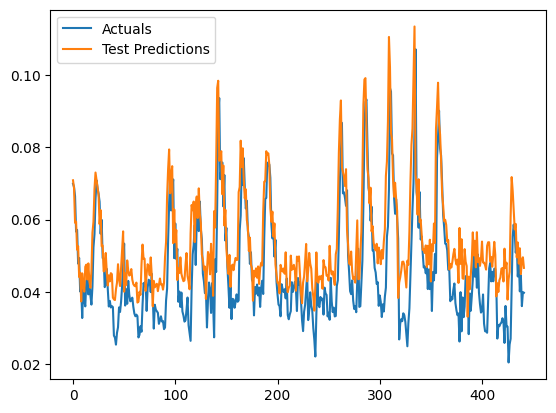

In [38]:
final, mse, r2, mape  = plot_predictions1(model5, X3_test, y3_test)
print(final,mse, r2, mape)



In [39]:

final=final.set_index(df['DateTime'][2436:].index)
print(final)

                     Predictions   Actuals
DateTime                                  
2020-11-12 14:00:00     0.069898  0.070841
2020-11-12 15:00:00     0.068972  0.068645
2020-11-12 16:00:00     0.066429  0.059088
2020-11-12 17:00:00     0.056654  0.059466
2020-11-12 18:00:00     0.057140  0.051650
...                          ...       ...
2020-11-30 19:00:00     0.040161  0.052057
2020-11-30 20:00:00     0.044608  0.044937
2020-11-30 21:00:00     0.036090  0.048803
2020-11-30 22:00:00     0.039959  0.049585
2020-11-30 23:00:00     0.039787  0.046653

[442 rows x 2 columns]
